In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from time_TvsR import *
from PebAcc_Turb import *
from matplotlib.colors import LogNorm
import os
import time

%matplotlib inline
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = (6,4)


In [2]:
def rate_odeint(m,t,p):
    alph,a_au,m_suns,temp,sig_gas,sig_p,st,verbose,verb_t = p
    cs = fn.sound_speed(temp)
    vth = fn.therm_vel(cs)
    om = fn.omega(m_suns*fn.m_sun, a_au*fn.au)
    H_g = cs/om
    rho_g = sig_gas/2./H_g
    rho_s = 2.
    vk = a_au*fn.au*om
    v0 = cs**2./2./vk
    m_earths = m/fn.m_earth
    s = st_solver(st=st,alph=alph,a_au=a_au,sig_in=sig_gas,temp_in=temp,m_earths=m_earths)
    
    rp = (3*m/4./np.pi/rho_s)**(1./3.)
    v_esc = np.sqrt(2*fn.G*m/rp)

    H_turb = np.sqrt(alph/(alph+st))*H_g
    H_KH = 2*v0/om
    H_p = max(H_turb,H_KH)
    rho_solid = sig_p/2./H_p
    v_turb = np.sqrt(alph)*cs/np.sqrt(1 + st)
    v_lam = v0*np.sqrt(1 + 4.*st**2.)/(1 + st**2.)
    v_inf = max(v_turb,v_lam)
    bGF = rp*(1 + (v_esc/v_inf)**2.)**(0.5)
    H_acc = min(H_p,bGF)
    sig_acc = 4*bGF*H_acc
    rate_GF = rho_solid*sig_acc*v_inf

    core = Core(a_core_au=a_au, m_core_earthmasses=m_earths, alpha=alph, m_star_solarmasses=m_suns, temp_in=temp,
                sig_p_in=sig_p, sig_g_in=sig_gas)
    core.main(s)
    rate_peb = m/(core.t_acc/fn.sec_to_years) # units of g/s?
    r_ws = core.r_ws
    h_r = core.r_hill
    b_r = core.r_bondi
    b_shear = core.r_sh
    #tmp,r_ws,h_r,b_r,b_shear = TvsR_sng(alph=alph,a_au=a_au,m_suns=m_suns,r=s,m_earths=m_earths,temp_in=temp,\
    #                               sig_g_in=sig_gas,sig_p_in=sig_p,out='len')
    r_tmp = min(r_ws,b_shear)
    r_stab = min(r_tmp,h_r)
    if bGF > r_stab:
        rate = rate_GF
    else:
        rate = rate_peb
#     rate = rate_peb + rate_GF
    print(rate_peb, rate_GF)
    return rate

In [23]:
a_au = 20 #0.5
M_dot = 1e-7
m_star = 1.
L_star = 1.
st = 1e-2

sig_gas_0 = 3000.
sig_gas = sig_gas_0*(a_au)**(-1.)

T_visc = 233.*(M_dot/1e-8)**(1./4.)*m_star**(1./4.)*(a_au)**(-1.)*(sig_gas_0/3000)**(1./4.) #From flow_iso_scratch notebook
T_irr = 150.*(L_star)**(2./7.)*m_star**(-1./7.)*a_au**(-3./7.)
T = max(T_visc,T_irr)

sig_p = 5.*a_au**(-1.)

a_cgs = a_au*fn.au
m_star_cgs = m_star*fn.m_sun

c_s = np.sqrt(fn.k*T/fn.mu)
om = np.sqrt(fn.G*m_star_cgs/a_cgs**3.)
vk = a_cgs*om
v_lam = c_s**2./2./vk
H = c_s/om

alpha = 1e-4 #(M_dot*fn.m_sun/3.154e7)/(3*np.pi*sig_gas*c_s*H)

v_turb = np.sqrt(alpha)*c_s

v_gas = np.sqrt(v_lam**2. + v_turb**2.)
aspect = H/a_cgs

rho_g = sig_gas/2./H

mfp = fn.mu/rho_g/fn.cross

In [26]:
m0_arr = np.multiply([1e-3,1e-4,1e-5],fn.m_earth)
times = np.logspace(3,6.5,num=1e5)/fn.sec_to_years

m_arr = np.zeros((len(m0_arr),len(times)))

for i,m0 in enumerate(m0_arr):
    p = [alpha,a_au,m_star,T,sig_gas,sig_p,st,1,0]
    wsol = odeint(rate_odeint,m0,times,args=(p,))
    m_arr[i] = wsol.flatten()

[5.21586359e+11] [1.90364586e+10]
[5.21586475e+11] [1.90364642e+10]
[5.21586475e+11] [1.90364642e+10]
[5.2158659e+11] [1.90364698e+10]
[5.2158659e+11] [1.90364698e+10]
[5.22745699e+11] [1.90928926e+10]
[5.227457e+11] [1.90928927e+10]
[5.23907383e+11] [1.91494826e+10]
[5.23907386e+11] [1.91494827e+10]
[5.25071651e+11] [1.92062404e+10]
[5.25071653e+11] [1.92062405e+10]
[5.34325645e+11] [1.96588579e+10]
[5.34325723e+11] [1.96588617e+10]
[5.32762246e+11] [1.95822065e+10]
[5.32762299e+11] [1.95822091e+10]
[5.40565642e+11] [1.99655403e+10]
[5.405656e+11] [1.99655382e+10]
[5.48483184e+11] [2.03563709e+10]
[5.48483194e+11] [2.03563714e+10]
[5.56516746e+11] [2.0754855e+10]
[5.56516756e+11] [2.07548555e+10]
[5.72938552e+11] [2.1575376e+10]
[5.72938601e+11] [2.15753785e+10]
[5.89845045e+11] [2.24283421e+10]
[5.89845025e+11] [2.24283411e+10]
[6.0725035e+11] [2.3315027e+10]
[6.07250331e+11] [2.3315026e+10]
[6.25169232e+11] [2.42367661e+10]
[6.25169236e+11] [2.42367663e+10]
[6.43616893e+11] [2.51949

[9.19129332e+14] [4.04888682e+14]
[9.19138637e+14] [4.04894147e+14]
[9.19127471e+14] [4.04887589e+14]
[9.19106707e+14] [4.04875393e+14]
[9.19102241e+14] [4.0487277e+14]
[9.19098724e+14] [4.04870705e+14]
[9.19099523e+14] [4.04871174e+14]
[9.19099523e+14] [4.04871174e+14]
[9.19100321e+14] [4.04871642e+14]
[9.19100321e+14] [4.04871642e+14]
[9.19101119e+14] [4.04872111e+14]
[9.19100672e+14] [4.04871849e+14]
[9.19101119e+14] [4.04872111e+14]
[9.1910052e+14] [4.0487176e+14]
[9.1910052e+14] [4.0487176e+14]
[9.1910072e+14] [4.04871877e+14]
[9.1910072e+14] [4.04871877e+14]
[9.19101119e+14] [4.04872111e+14]
[9.19101007e+14] [4.04872046e+14]
[9.19101119e+14] [4.04872111e+14]
[9.19100896e+14] [4.0487198e+14]
[9.191008e+14] [4.04871924e+14]
[9.19100755e+14] [4.04871897e+14]
[9.191008e+14] [4.04871924e+14]
[9.1910074e+14] [4.04871889e+14]
[9.1910076e+14] [4.048719e+14]
[9.191008e+14] [4.04871924e+14]
[9.19100789e+14] [4.04871917e+14]
[9.191008e+14] [4.04871924e+14]
[9.1910077e+14] [4.04871906e+14]
[

[1.21589136e+14] [2.72915147e+13]
[1.29824284e+14] [2.97835042e+13]
[1.29824293e+14] [2.97835069e+13]
[1.38617229e+14] [3.25030487e+13]
[1.38617213e+14] [3.25030439e+13]
[1.48005671e+14] [3.54709018e+13]
[1.48005672e+14] [3.54709023e+13]
[1.58030002e+14] [3.87097554e+13]
[1.58030006e+14] [3.87097566e+13]
[1.68733279e+14] [4.22443504e+13]
[1.68733282e+14] [4.22443516e+13]
[1.90760727e+14] [4.97530264e+13]
[1.90760762e+14] [4.97530387e+13]
[2.15663757e+14] [5.85963202e+13]
[2.15663837e+14] [5.85963491e+13]
[2.10585404e+14] [5.67638477e+13]
[2.10585445e+14] [5.67638625e+13]
[2.32470444e+14] [6.47626181e+13]
[2.32470401e+14] [6.47626021e+13]
[2.56629717e+14] [7.38884576e+13]
[2.56629731e+14] [7.38884629e+13]
[2.83299802e+14] [8.43002719e+13]
[2.83299806e+14] [8.43002734e+13]
[3.12741545e+14] [9.6179237e+13]
[3.12741551e+14] [9.61792392e+13]
[3.45243e+14] [1.09732097e+14]
[3.45243009e+14] [1.09732101e+14]
[5.21586359e+09] [41126193.67813453]
[5.21586475e+09] [41126205.83285266]
[5.21586475e

No handles with labels found to put in legend.


(1e-06, 200.0)

/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


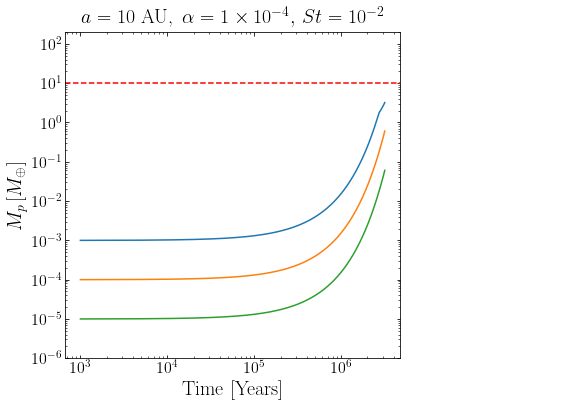

In [28]:
fig = plt.figure(figsize=(6,6))

# labels = [r'$M_0 = 10^{-7} M_\oplus$',r'$M_0 = 10^{-6} M_\oplus$',r'$M_0 = 10^{-5} M_\oplus$']

for i in range(len(m0_arr)):
    plt.loglog(times*fn.sec_to_years,m_arr[i]/fn.m_earth)
    
# plt.ylim([1e-8,1e2])
plt.xlabel('Time [Years]',fontsize=20)
plt.ylabel(r'$M_p \, [M_\oplus]$',fontsize=20)

plt.axhline(y=1e1,linestyle='dashed',color='r')

lgd = plt.gca().legend(bbox_to_anchor=[1.55,0.70],frameon=False)

plt.title(r'$a = 10$ AU,\, $\alpha = 1 \times 10^{-4}, \, St = 10^{-2}$',y=1.01)
plt.ylim(1e-6,2e2)
# plt.tight_layout()

In [17]:
fig.savefig('M_vs_t.pdf',bbox_inches='tight')